In [1]:
!pip install tensorflow==2.14 keras==2.14 tensorflow-addons==0.21
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow_addons as tfa

from datetime import datetime
import tensorboard



/usr/local/lib/python3.11/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.11.0 and strictly below 2.14.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.14.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're u

mv: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/camnugent/california-housing-prices
License(s): CC0-1.0
  0% 0.00/400k [00:00<?, ?B/s]
100% 400k/400k [00:00<00:00, 75.7MB/s]
Archive:  california-housing-prices.zip
  inflating: housing.csv             
Epoch 1/50
511/511 [==============================] - 5s 9ms/step - loss: 55400759296.0000 - mean_absolute_error: 205507.9688 - root_mean_squared_error: 235373.6562 - val_loss: 54566514688.0000 - val_mean_absolute_error: 203009.8594 - val_root_mean_squared_error: 233594.7656
Epoch 2/50
511/511 [==============================] - 2s 5ms/step - loss: 48259895296.0000 - mean_absolute_error: 189883.6875 - root_mean_squared_error: 219681.3438 - val_loss: 41385078784.0000 - val_mean_absolute_error: 173113.7031 - val_root_mean_squared_error: 203433.2344
Epoch 3/50
511/511 [==============================] - 2s 4ms/step 

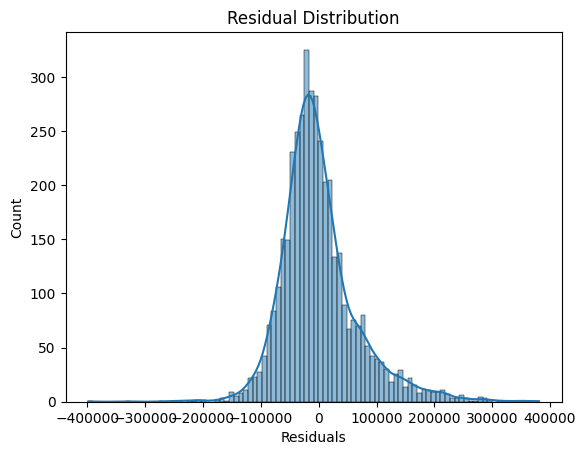

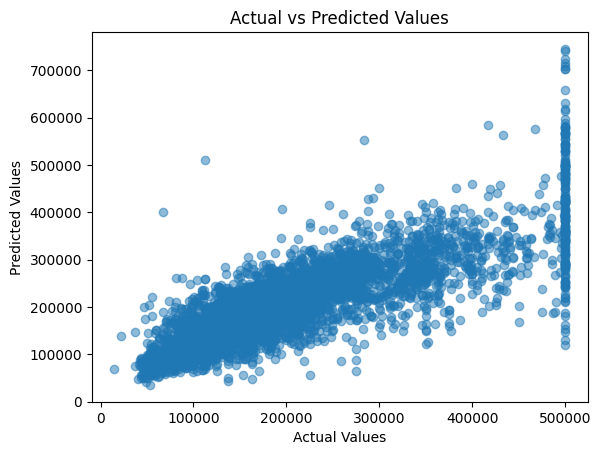

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [2]:

!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d camnugent/california-housing-prices
!unzip california-housing-prices.zip

# Load Dataset
df = pd.read_csv("housing.csv")
df = df.dropna()  # Drop missing values

# Split
X = df.drop(columns=['median_house_value'])
y = df['median_house_value']

X = pd.get_dummies(X, columns=['ocean_proximity'])

# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Regression Model
model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])

# Compile Model
model.compile(optimizer='adam',
              loss='mse',
              metrics=[tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.RootMeanSquaredError()])

# TensorBoard Callback
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=f"logs/fit/{datetime.now().strftime('%Y%m%d-%H%M%S')}", histogram_freq=1)

# Train Model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    callbacks=[tensorboard_callback]
)

# Evaluate Model
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"R² Score: {r2}")

# Residual Plot
residuals = y_test - y_pred.flatten()
sns.histplot(residuals, kde=True)
plt.xlabel("Residuals")
plt.title("Residual Distribution")
plt.show()

# Scatter Plot of Predictions vs Actual
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Values")
plt.show()

# Save Model
model.save("california_housing_regressor.h5")